#### COLLABORATIVE FILTERING MODEL WITH AUTOENCODER LATENT FEATURES AND EMBEDDINGS

In [2]:
PATH = '/home/g056122/DAFERS'
DATAPATH = '/home/g056122/ISG_studienarbeit/ml-1m'

In [3]:
# import required libraries
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from testdata import testdata
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from scipy.special import expit
import seaborn as sns

In [4]:
# load users data preprocessing pickle file
[df, dftrain, dftest, df, dfratings, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx]=pickle.load(open(f'{PATH}/1UsersData.pkl','rb'))

In [5]:
# split dataset to train-test data
dftrain=df.loc[df['train']=='train']
dftest=df.loc[df['train']!='train']

DATA PREPARATION

In [6]:
# load users autoencoder latent features pickle file
[dftrain_userauto, dftest_userauto, user_mtx_1_weights, user_mtx_2_weights, dftrain_userauto_linear, dftest_userauto_linear] = pickle.load(open(f'{PATH}/2UserAutoencoderWeights.pkl','rb'))

In [7]:
# load items autoencoder latent features pickle file
[dftrain_itemauto, dftest_itemauto, item_mtx_1_weights, item_mtx_2_weights, dftrain_itemauto_linear, dftest_itemauto_linear] = pickle.load(open(f'{PATH}/3ItemAutoencoderWeights.pkl','rb'))

In [8]:
# rename index 
dftrain_itemauto = dftrain_itemauto.rename(columns={'item_idx':'movie_idx'})
print(dftrain.shape)
# merge dftrain and dftrain_itemauto
dftrain=pd.merge(dftrain,dftrain_itemauto,on='movie_idx',how='left')
print(dftrain.shape)
# rename index
dftrain_userauto = dftrain_userauto.rename(columns={'index':'user_idx'})
# merge dftrain and dftrain_userauto
dftrain=pd.merge(dftrain,dftrain_userauto,on='user_idx',how='left')
print(dftrain.shape)

(900188, 21)
(900188, 46)
(900188, 71)


In [9]:
# rename index
dftest_itemauto = dftest_itemauto.rename(columns={'item_idx':'movie_idx'})
print(dftest.shape)
# merge df_valid and df_valid_item_autoenc
dftest=pd.merge(dftest,dftest_itemauto,on='movie_idx',how='left')
print(dftest.shape)
# rename index
dftest_userauto = dftest_userauto.rename(columns={'index':'user_idx'})
# merge df_valid and df_valid_user_autoenc
dftest=pd.merge(dftest, dftest_userauto,on='user_idx',how='left')
print(dftest.shape)

(100021, 21)
(100021, 46)
(100021, 71)


In [10]:
# data preprocessing
autoenc_cols=dftrain.columns[dftrain.columns.str.contains('autoenc')]
autoenc_cols=autoenc_cols.tolist()

DATASET AND DATALOADER

In [11]:
dstrain = testdata( dftrain[['user_idx','movie_idx'] + autoenc_cols], dftrain['rating'], autoenc_cols)
dsvalid = testdata( dftest[['user_idx','movie_idx'] + autoenc_cols], dftest['rating'], autoenc_cols)

In [12]:
# batch_size
bs = 128 
# load dataloader object
dltrain=DataLoader(dstrain,bs,True)
dlvalid=DataLoader(dsvalid,bs,True)

MODEL ARCHITECTURE

In [13]:
# model parameters
n_users=len(user_to_idx)
n_movies=len(movie_to_idx)
n_emb_user=50
n_emb_movie=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.1
hidden=[25,10,10]
dropouts=[0.2,0.3,0.2]

In [14]:
# hidden layer architecture
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    ''' Function to create hidden layer architecture '''
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [15]:
# load pretrained weights pickle
pretrain_wts=pickle.load(open(f'{PATH}/4BaseEmbeddingsWeights','rb'))

In [16]:
# create subclass for neural network module
class test(nn.Module):    
    def __init__(self, n_users, n_emb_user, n_emb_item, n_items, min_rating, max_rating, autoenc_cols, pretrain_wts, dropout_e=0.01, hidden=[15,5], dropouts=[0.2,0.2], error_type="mse"):
        # call parent class constructor in subclass using super function
        super().__init__()
        self.n_users, self.n_emb_user, self.n_emb_item, self.n_items, self.min_rating, self.max_rating = n_users, n_emb_user, n_emb_item, n_items, min_rating, max_rating
        self.dropout_e, self.hidden, self.dropouts = dropout_e, hidden, dropouts
        self.autoenc_cols, self.len_dense_cols = autoenc_cols, len(autoenc_cols)
        self.create_architecture()
        
        if pretrain_wts is not None:
            # intialize pre-trained weights
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        '''
        Function to create model architecture
        '''
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
      
    def init_parameters(self):
        ''' Function to initialize the weights for the layers'''
        # initialize weight parameter using the Kaiming normal initialization
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
       
    def forward (self,Xb,Yb):
        ''' 
        Function to perform forward pass
        '''
        users = Xb[:,0].long()
        items = Xb[:,1].long()
        users = self.emb_dropout(self.emb_user(users))
        items = self.emb_dropout(self.emb_item(items))
        users_bias = self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias = self.emb_dropout(self.ib(Xb[:,1].long()))
        embed = torch.cat([users,items],1)
        out1 = self.lin1(embed)
        bias = torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased = self.lin_bias(bias)
        denses = Xb[:,2:]
        out2 = self.lin2(denses)
        out3 = torch.cat([out1,out2,biased],1)
        out4 = self.lin3(out3)
        out5 = self.lin4(out4)
        out = self.sigmoid(out5)
        preds = out*(self.max_rating-self.min_rating)+self.min_rating
        loss=self.criterion(preds,Yb)
        return preds,loss

MODEL LEARNER

In [17]:
class model_learner():
    def __init__(self, model, optimizer, metric_fn, device, bptt = 12, print_every = 5, clip_val = None,\
                 cycle_mult = 0, lr_decay = 0.7, wd_mult = 6, start_lr = 2e-2, end_lr = 5e-4, error_type = "mse"):
        self.model, self.optimizer, self.metric_fn, self.device, self.print_every, self.bptt, self.losses, self.clip_val=\
            model, optimizer, metric_fn, device, print_every, bptt, [], clip_val
        self.n_epochs = 1
        self.cycle_mult, self.lr_decay = cycle_mult, lr_decay
        self.wd_mult = wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        
    def fit (self,Xb,Yb,mode_train=True):
        ''' 
        Function to make predictions and loss
        '''
        if mode_train:
            # set model to training mode
            self.model.train()
        else:
            # set model to evalaute mode
            self.model.eval()
        
        preds, loss = self.model(Xb, Yb)

        if mode_train:
            if 1==0:
                lr = self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr
            
            # clear gradients of all optimized parameters
            self.optimizer.zero_grad()
            # compute gradients of loss with respect to parameters of neural network
            loss.backward()
           # update model parameters
            self.optimizer.step()
        # compute loss
        myloss = loss.item()
    
        with torch.no_grad():
            if self.error_type == "mse":
                acc = nn.L1Loss() (preds,Yb)
                myrmse = np.sqrt(myloss)
            else:
                acc = nn.MSELoss() (preds,Yb)
                myrmse = np.sqrt(acc.item())
            acc = acc.item()
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self, start_lr, end_lr, iterator, n_batch):
        ''' 
        Function to determine optimal learning rate for the model
        '''
        losses, lrs = [], []
        ratio = end_lr/start_lr
        num_steps = n_batch
        lr = start_lr
        for i in range(num_steps):      
            # learning rate schedule to gradually decrease the learning rate over time         
            lr=lr*(ratio)**(1/num_steps)
            lrs.append(lr)
        self.lrs = lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        ''' 
        Function to train the model for one epoch
        '''
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb = Xb
            Yb = Yb
            
            if lrs is not None:
                lr = lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss, acc, myrmse = self.fit( Xb, Yb, mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k = k+1
            # if k%self.print_every == 0:
            #     if k:
            #         print (f'Batch:{k} {epoch_loss/(k)}  ')  
        epoch_loss = epoch_loss / len(iterator)
        epoch_acc = epoch_acc / len(iterator)
        epoch_rmse = epoch_rmse / len(iterator)
            
        return epoch_loss, epoch_acc, epoch_rmse
    
    def plot_lrs(self, n_roll=1, ylim=None, xlim=None):
        ''' 
        Function to plot graph of learning rate vs loss
        '''
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

    def run_epochs(self,dltrain,dlvalid,n_epochs=1):    
        ''' 
        Function to run epochs for n_epochs
        '''   
        pltloss, pltlossv=[], []       
        for epoch in range(n_epochs):                
            loss, acc, rmse = self.run_epoch(dltrain,True)
            lossv, accv, rmsev = self.run_epoch(dlvalid,mode_train=False)

            # append loss values 
            pltloss.append(loss)
            pltlossv.append(lossv)

            if self.error_type=="mse":
                loss_mse = loss
                loss_rmse = rmse
                loss_mae = acc
                lossv_mse = lossv
                lossv_rmse = rmsev
                lossv_mae = accv
            else:
                loss_mse = acc
                loss_rmse = rmse
                loss_mae = loss
                lossv_mse = accv
                lossv_rmse = rmsev
                lossv_mae = lossv
            
            print (f'Epoch:{epoch+1} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.reset_cycle*=self.cycle_mult
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
        
        # # set the x-axis range
        # plt.xlim((1, (len(pltloss)+1)))
        
        # plot train-test learning curve
        plt_x = np.arange(1, n_epochs+1)
        plt.plot(plt_x, pltloss, label='Train Loss')
        plt.plot(plt_x, pltlossv, label='Test Loss')
        
        # set plot labels and title
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curve (DNN with autoencoder and embeddings)')

        # add a legend
        plt.legend(loc='upper right')

        # display the plot
        plt.show()

In [18]:
# model architecture object
testobj = test(n_users, n_emb_user, n_emb_movie, n_movies, min_rating, max_rating, autoenc_cols, pretrain_wts, dropout_e, hidden, dropouts, error_type="mse")
# optimizer
optimizer = torch.optim.Adam(testobj.parameters(),lr=3e-4,betas=(0.9,0.999), weight_decay=1e-7)
# model learner object
learner = model_learner(testobj, optimizer, None, 0, 16000, 0.25, cycle_mult = 10, error_type = "mse")

In [19]:
# learner.run_epochs(dltrain,dlvalid,10)

In [20]:
# model architecture object
testobj = test(n_users, n_emb_user, n_emb_movie, n_movies, min_rating, max_rating, autoenc_cols, pretrain_wts, dropout_e, hidden, dropouts, error_type="mse")
# optimizer
optimizer = torch.optim.Adam(testobj.parameters(),lr=4.75e-4,betas=(0.9,0.999), weight_decay=1e-7)
# model learner object
learner = model_learner(testobj, optimizer, None, 0, 16000, 0.25, cycle_mult = 10, error_type = "mse")

Epoch:1 Learning rate 0.000475 Weight Decay 1e-07 Train Loss:0.8517184389293507 Valid Loss:0.7604867742418329 Train RMSE:0.9196900626498953 Valid RMSE:0.870097280998313 Train MSE:0.8517184389293507 Valid MSE:0.7604867742418329                 Train MAE:0.7337756733136345 Valid MAE:0.6887919499593622
Epoch:2 Learning rate 0.00047744269081074987 Weight Decay 1e-07 Train Loss:0.7731732659568391 Valid Loss:0.7422361421539351 Train RMSE:0.8772526332073209 Valid RMSE:0.8594524543057778 Train MSE:0.7731732659568391 Valid MSE:0.7422361421539351                 Train MAE:0.6960879685816717 Valid MAE:0.6789177825383823
Epoch:3 Learning rate 0.00047989794317601956 Weight Decay 1e-07 Train Loss:0.7535754440265717 Valid Loss:0.7353977322807093 Train RMSE:0.8660397402311363 Valid RMSE:0.8553745846393721 Train MSE:0.7535754440265717 Valid MSE:0.7353977322807093                 Train MAE:0.6859410630678632 Valid MAE:0.6765516529150326
Epoch:4 Learning rate 0.0004823658216936908 Weight Decay 1e-07 Trai

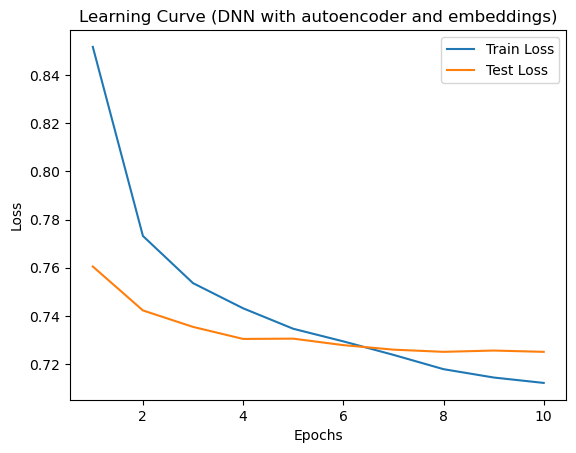

In [21]:
learner.run_epochs(dltrain,dlvalid,10)

In [23]:
# model architecture object
testobj = test(n_users, n_emb_user, n_emb_movie, n_movies, min_rating, max_rating, autoenc_cols, pretrain_wts, dropout_e, hidden, dropouts, error_type="mse")
# optimizer
optimizer = torch.optim.Adam(testobj.parameters(),lr=4.75e-4,betas=(0.9,0.999), weight_decay=1e-7)
# model learner object
learner = model_learner(testobj, optimizer, None, 0, 16000, 0.25, cycle_mult = 10, start_lr = 4e-4, end_lr = 5e-5, error_type = "mse")

Epoch:1 Learning rate 0.000475 Weight Decay 1e-07 Train Loss:0.8128275455027442 Valid Loss:0.7422460704432119 Train RMSE:0.8985101591114687 Valid RMSE:0.8594704544950115 Train MSE:0.8128275455027442 Valid MSE:0.7422460704432119                 Train MAE:0.7157527373844913 Valid MAE:0.6779636424368299
Epoch:2 Learning rate 0.0003792462097737139 Weight Decay 1e-07 Train Loss:0.7407830182246289 Valid Loss:0.7305174178022253 Train RMSE:0.8586562726115299 Valid RMSE:0.8525188582392014 Train MSE:0.7407830182246289 Valid MSE:0.7305174178022253                 Train MAE:0.6783054737215545 Valid MAE:0.6702357149490005
Epoch:3 Learning rate 0.000302795131847848 Weight Decay 1e-07 Train Loss:0.7248714231765069 Valid Loss:0.7266278668590214 Train RMSE:0.8493819181977873 Valid RMSE:0.8505869713541939 Train MSE:0.7248714231765069 Valid MSE:0.7266278668590214                 Train MAE:0.6699693848216209 Valid MAE:0.6697599926720494
Epoch:4 Learning rate 0.00024175559177100697 Weight Decay 1e-07 Train

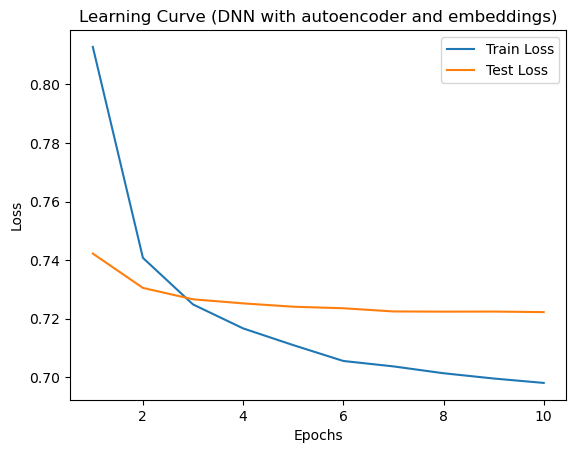

In [24]:
learner.run_epochs(dltrain,dlvalid,10)

In [22]:
# # save objects and parameters as pickle file
# torch.save(testobj,f=f'{PATH}/5Cfobj')
# torch.save(learner,f=f'{PATH}/5CfLearner')
# torch.save(optimizer,f=f'{PATH}/5Optimizer')
# torch.save(testobj.state_dict(),f'{PATH}/5CfStateDict')
# torch.save(optimizer.state_dict(),f'{PATH}/5CfOptimizerStateDict')